In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.dynamics import msd_from_gsd
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import os
import shutil

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 3
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 1

colors = [
    "#FF5733",  # Vermilion
    "#FFC300",  # Saffron
    "#4B0082",  # Indigo
    "#00A86B",  # Jade
    "#007FFF",  # Azure
    "#D2691E",  # Chocolate
    "#FF4500",  # Orange Red
    "#6A0DAD",  # Purple
    "#2E8B57",  # Sea Green
    "#FF6EC7",  # Blush Pink
    "#800080",  # Purple
    "#4682B4",  # Steel Blue
    "#008B8B",  # Dark Cyan
    "#E9967A",  # Dark Salmon
    "#FFD700"   # Gold
]

def kT_to_T(kT, epsilon):
    return ((kT*epsilon)/8.31446262) - 273.15

SAVE_FIGS = True

In [3]:
project = signac.get_project("../validation/")

520
520


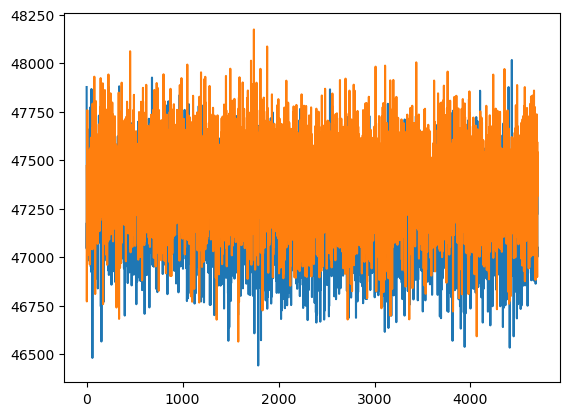

In [3]:
for job in project.find_jobs({"doc.volume_sampled": True}):
    if job.doc.nvt_runs < 1:
        continue
    if job.sp.kT != 1.8:
        continue
    data = np.genfromtxt(job.fn("log-nvt0.txt"), names=True)
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    pressure = data["mdcomputeThermodynamicQuantitiespressure"]
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    plt.plot(pe[500:])
    with gsd.hoomd.open(job.fn("trajectory-nvt0.gsd")) as traj:
        print(len(traj))

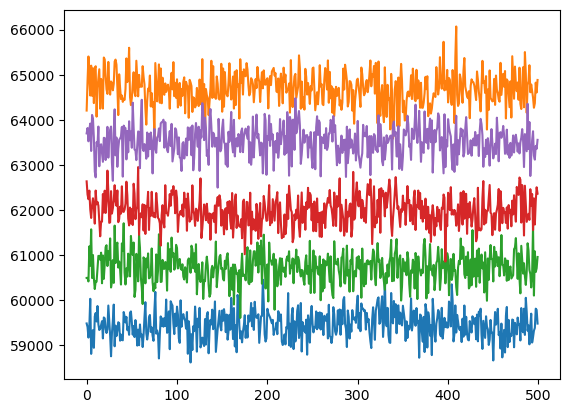

In [3]:
for job in project.find_jobs({"doc.skip_npt_equil": True, "doc.nvt_equilibrated": False}):
    if job.doc.nvt_runs < 1:
        continue
    data = np.genfromtxt(job.fn("log-nvt0.txt"), names=True)
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    pressure = data["mdcomputeThermodynamicQuantitiespressure"]
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    plt.plot(pe[-500:])

# Check for NVT equilibration:

In [20]:
for job in project.find_jobs(filter={
    "doc.nvt_equilibrated": True,
    "doc.npt_equilibrated": True,
    "sigma_scale": 0.955
    #"doc.skip_npt_equil": True
}
):
    #if job.doc.nvt_runs < 1:
    #    continue
    print(job.id, job.sp.kT)
    continue
    fpath = job.fn(f"log-nvt{job.doc.nvt_runs-1}.txt")
    data = np.genfromtxt(fpath, names=True)
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    sample_idx = 500
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.20, threshold_neff=200)[0]
    if pe_eq is True:
        print("equilibrated")
        print(job)
        job.doc.nvt_equilibrated = True
    else:
        print("not equilibrated")
        print(job, job.sp.kT)
        job.doc.nvt_equilibrated = False
    print()

212e36add95bb5744b05aa8ce8d29449 4.6
1cbc57c38be8cfe0ae9994bcb19467e2 2.5
24e102558a3471c0accad805e64ff332 4.2
887213b5081db9f0d4bb1b606c0206a4 3.8
2ec7855f992bf53446f9a3adf393b528 1.2
ddff72030898e479189cd2df660938e3 3.6
2c8f7b80326a4107044f93abf255c176 1.0
8fa6d7ddef1517ec38bbf688c5c0dab5 2.0
9a2350bfd349debae443b6dd5f1beb2f 2.9
825d861b4c33b56fe804d6f0791b175f 1.8
a5250cea52a262d308592249ce463d10 2.6
d4f337da0a7ee79a1778c858471aa917 3.2
9142f5e776ff060fb7edb01495a9a86e 2.4
28aa0133175e9cf18fd68e541cb012ee 4.4
73e2a18dd6e440ba0066c934fcb829e0 3.0
39edcdb395b6b0d3c3028c6feb7547af 3.4
ce33582b39a1fd612b1e122e43934d46 2.2
96282e58fc96112640e1330198828903 4.0
4ba943c66884b09b14ae768da5ce9149 1.6
100888a4bbe8114d13b7c682ba77a678 3.1
da265101b694310d8f3228d10858e512 1.4
51e475756aeadda668351a024760dcda 2.8


In [8]:
for job in project.find_jobs(filter={"doc.nvt_equilibrated": True, "doc.msd_sampled": True}):
    fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")
    new_path = job.fn("trajectory-nvt-msd.gsd")
    shutil.copy(fpath, new_path)

# Calculate MSD:

393a1cc581d5324e470714d7c681dcac 2.7


/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


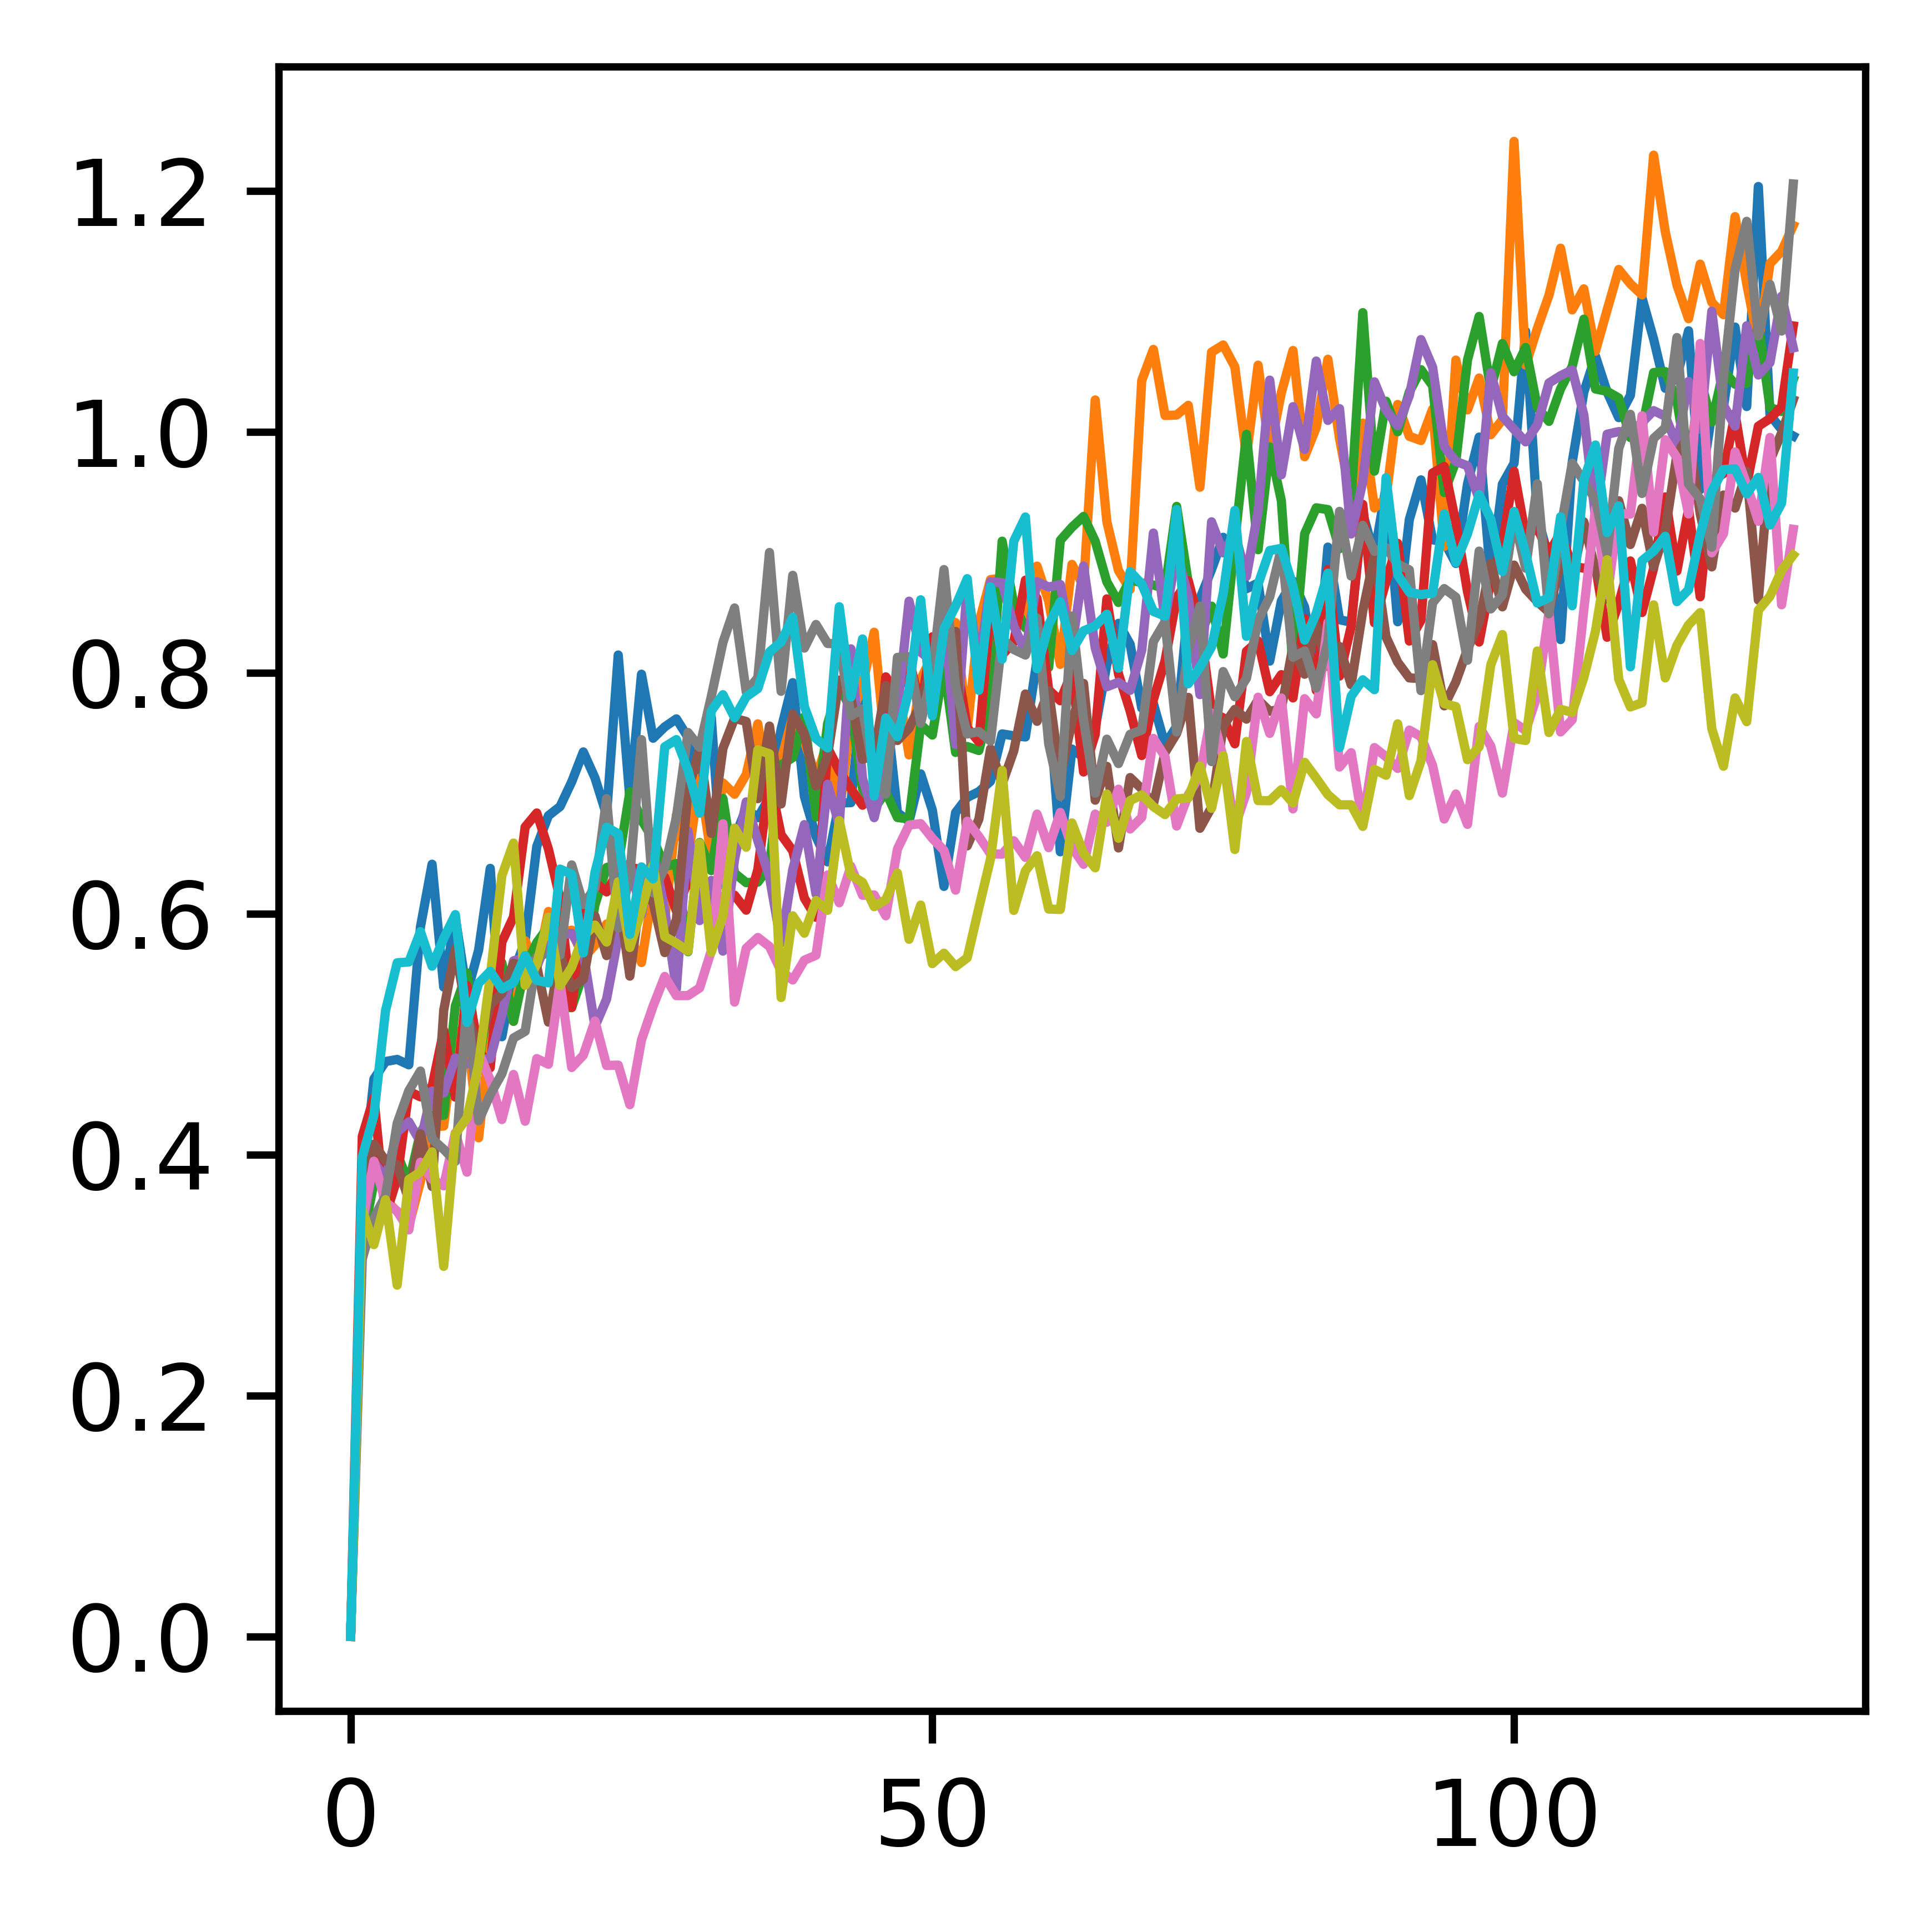

In [22]:
chunk_size = 125
start_frame = 20
end_frame = 500 - chunk_size
n_samples = 10

fig = plt.figure()

for job in project.find_jobs(filter={"doc.nvt_equilibrated": True, "doc.msd_sampled": False, "sigma_scale": 0.955}):
    print(job.id, job.sp.kT)
    fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")
    fpath = job.fn("trajectory-nvt-msd.gsd")
    with gsd.hoomd.open(fpath) as traj:
        end_frame = len(traj) - chunk_size
        random_starts = np.random.randint(start_frame, end_frame, n_samples)
        
    window_slopes = []
    steps_per_frame = job.sp.gsd_write_freq
    ts = job.doc.real_time_step * 1e-15
    ts_frame = steps_per_frame * ts
    
    for i in random_starts:
        msd = msd_from_gsd(
            gsdfile=fpath,
            start=int(i),
            stop=int(i) + chunk_size,
            atom_types="all",
            msd_mode="direct"
        )
        
        msd_data = np.copy(msd.msd)
        msd_data *= job.doc.ref_length**2 * 1e-18
        time = np.arange(0, chunk_size, 1) * ts_frame
        mid_chunk = msd_data[len(msd_data)//4:-len(msd_data)//4]
        mid_chunk_time = time[len(time)//4:-len(time)//4]
        window_slopes.append((mid_chunk[-1] - mid_chunk[0])/(mid_chunk_time[-1] - mid_chunk_time[0]))
        plt.plot(msd.msd)
    job.doc.D = np.mean(window_slopes)
    job.doc.D_std = np.std(window_slopes)
    job.doc.msd_sampled = True

plt.tight_layout()

# Analysis: Plot $D_{self}$ vs Temperature

100888a4bbe8114d13b7c682ba77a678 3.1 123.9291800853631
9a2350bfd349debae443b6dd5f1beb2f 2.9 98.31116846695261
9142f5e776ff060fb7edb01495a9a86e 2.4 34.266139420926265
887213b5081db9f0d4bb1b606c0206a4 3.8 213.59222074979994
39edcdb395b6b0d3c3028c6feb7547af 3.4 162.3561975129789
ce33582b39a1fd612b1e122e43934d46 2.2 8.648127802515774
ddff72030898e479189cd2df660938e3 3.6 187.97420913138944
1cbc57c38be8cfe0ae9994bcb19467e2 2.5 47.07514523013157
a5250cea52a262d308592249ce463d10 2.6 59.884151039336814
51e475756aeadda668351a024760dcda 2.8 85.5021626577473
73e2a18dd6e440ba0066c934fcb829e0 3.0 111.12017427615785
d4f337da0a7ee79a1778c858471aa917 3.2 136.73818589456835


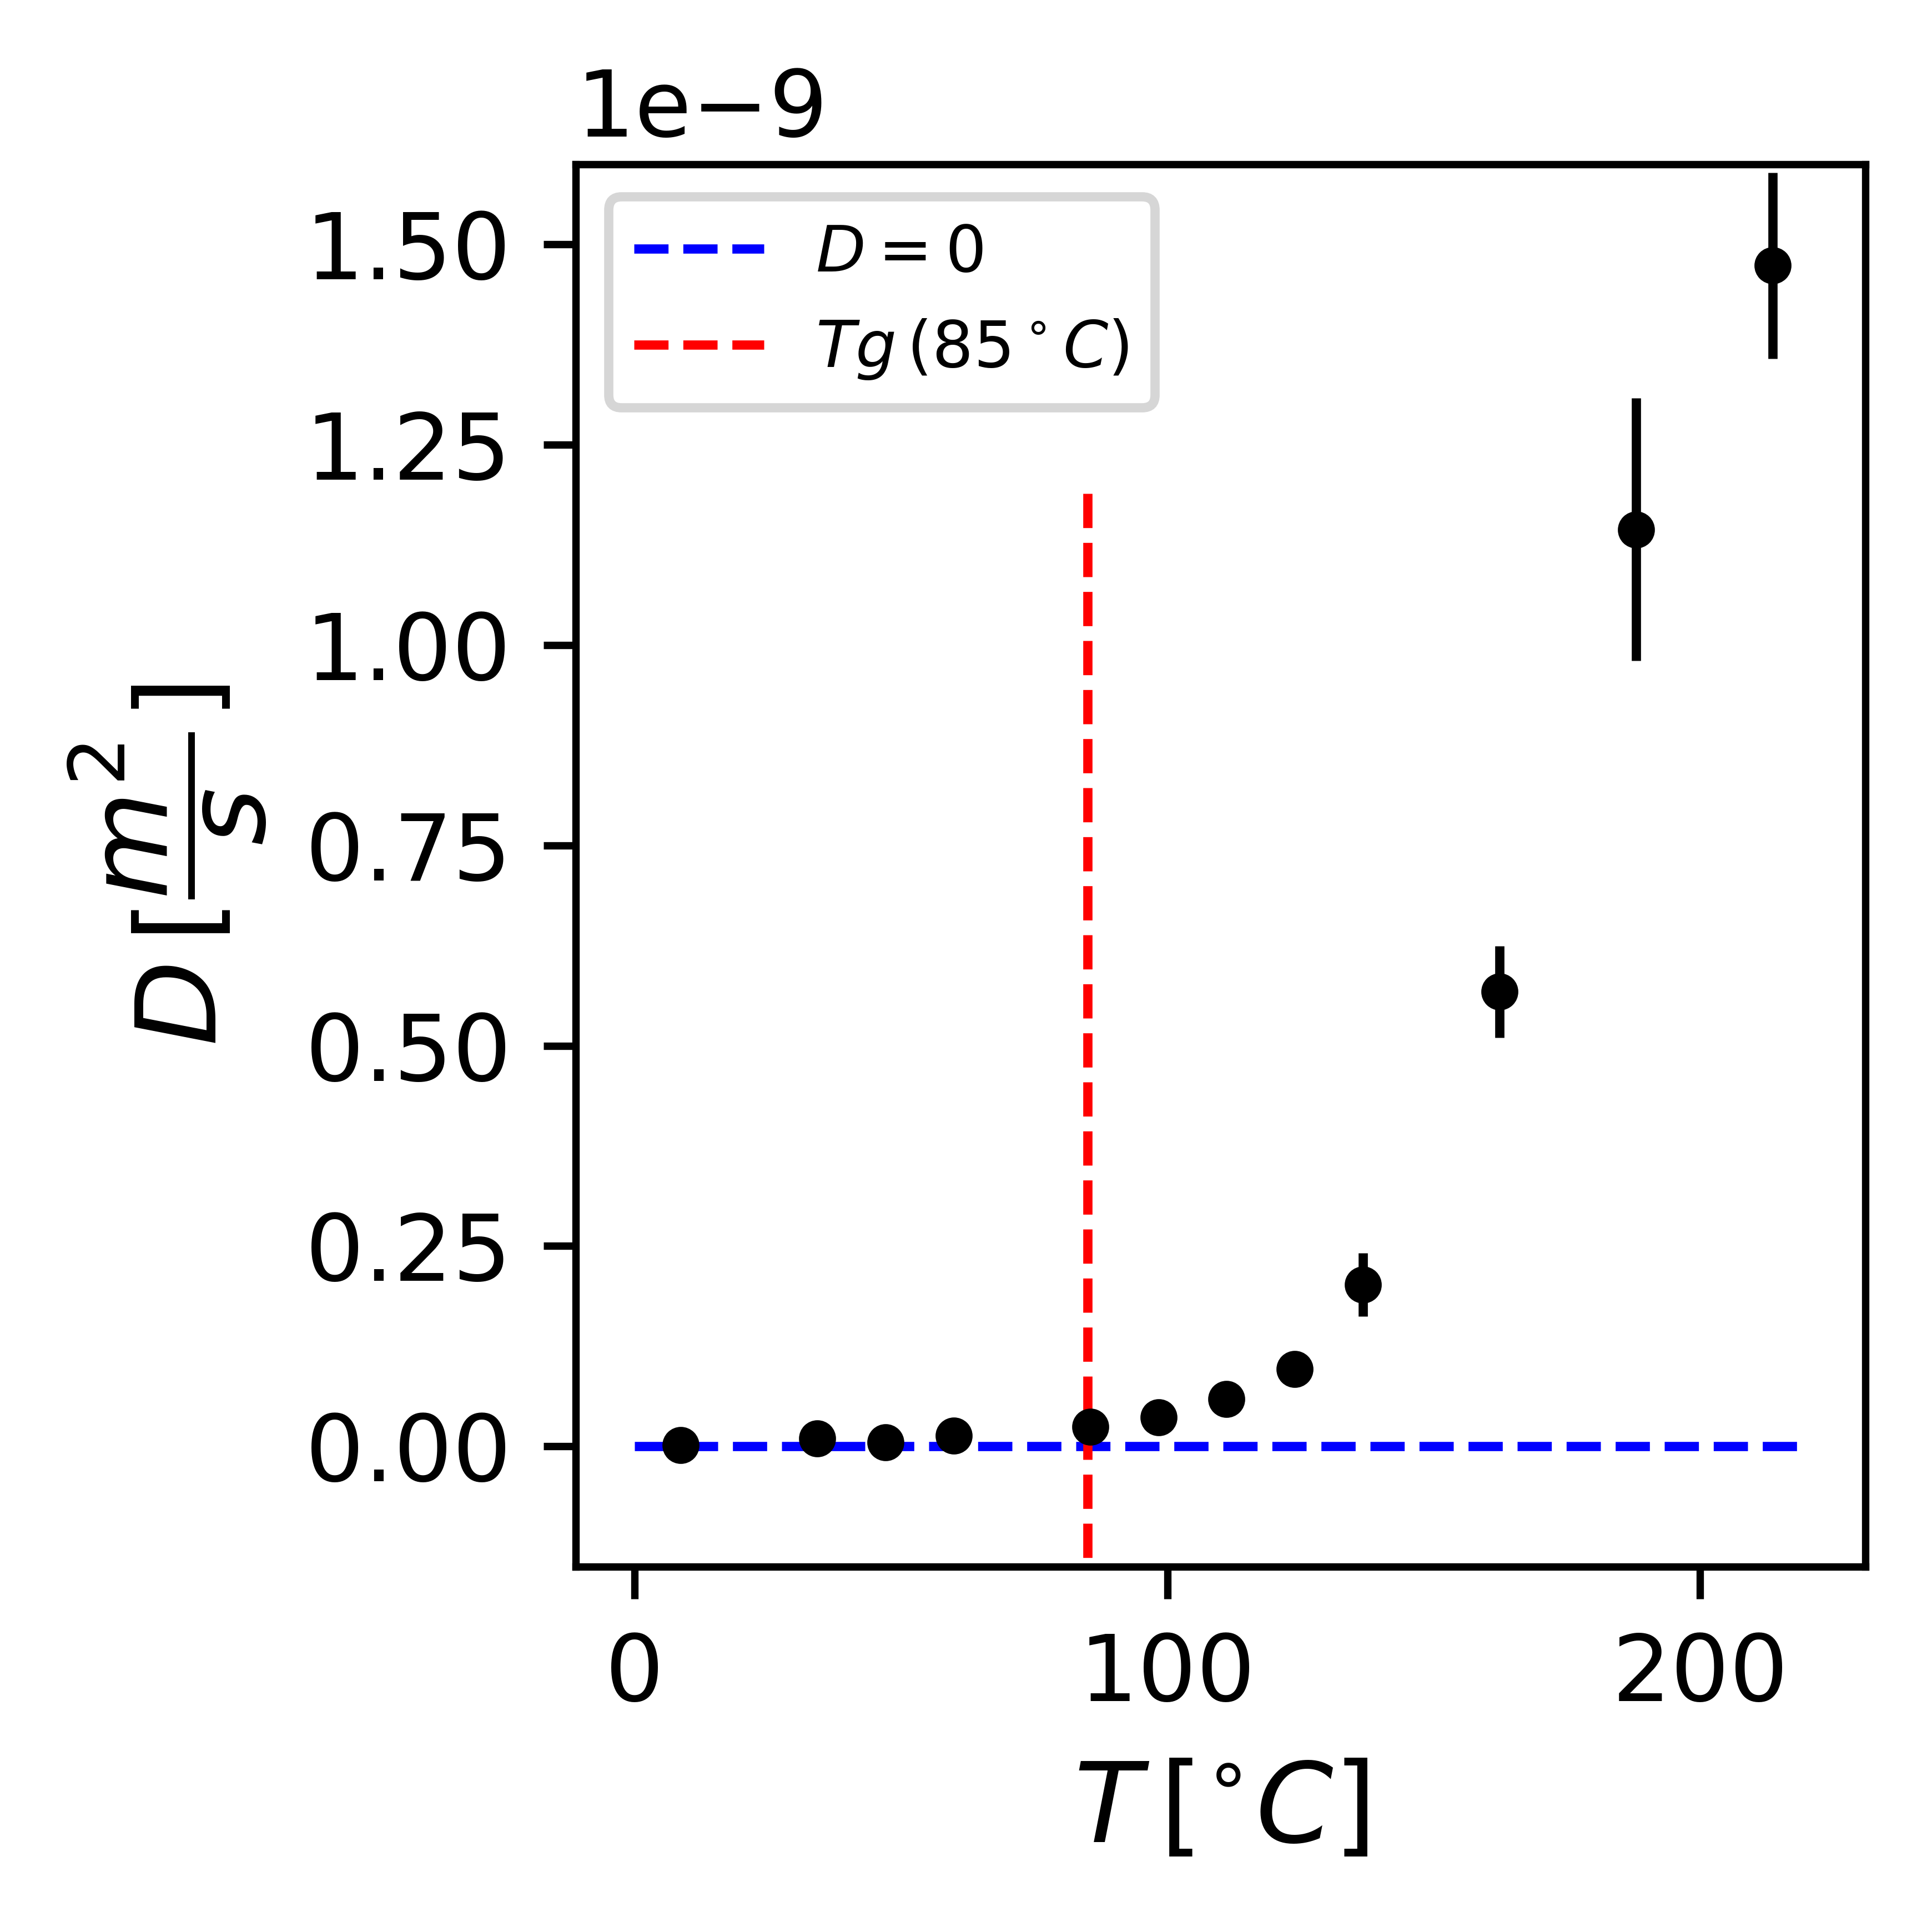

In [5]:
for job in project.find_jobs(filter={"doc.nvt_equilibrated": True, "doc.msd_sampled": True, "sigma_scale": 0.955}):
    if job.sp.kT < 2.2: continue
    if job.sp.kT == 2.8:
        c="k"
        label="Tg"
    else:
        c="k"
    T = kT_to_T(job.sp.kT, epsilon=1065)
    print(job.id, job.sp.kT, T)
    plt.errorbar(x=T, y=job.doc.D, yerr=job.doc.D_std, marker="o", color=c, markersize=3)

plt.hlines(xmin=0, xmax=220, y=0, ls="--", color="blue", label="$D = 0$")
plt.vlines(x=(358.15-273.15), ymin=-0.2e-9, ymax=1.20E-9, label="$Tg\,(85^\circ C)$", linestyle="--", color="r")
plt.xlabel("$T\,[^{\circ}C]$")
plt.ylabel("$D\,[\dfrac{m^2}{s}]$")
plt.legend(loc="upper left")
plt.ylim(-0.15e-9, 1.60e-9)
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/ua-msd-tg.png")

In [15]:
for kT, jobs in project.find_jobs(filter={"doc.nvt_equilibrated": True, "doc.msd_sampled": True, "sigma_scale": 0.955}).groupby("kT"):
    for job in jobs:
        T = kT_to_T(job.sp.kT, epsilon=1065)
        print(job.id, job.sp.kT, T)

2c8f7b80326a4107044f93abf255c176 1.0 -145.05994190794738
2ec7855f992bf53446f9a3adf393b528 1.2 -119.44193028953686
da265101b694310d8f3228d10858e512 1.4 -93.82391867112634
4ba943c66884b09b14ae768da5ce9149 1.6 -68.20590705271582
825d861b4c33b56fe804d6f0791b175f 1.8 -42.58789543430527
8fa6d7ddef1517ec38bbf688c5c0dab5 2.0 -16.969883815894775
ce33582b39a1fd612b1e122e43934d46 2.2 8.648127802515774
9142f5e776ff060fb7edb01495a9a86e 2.4 34.266139420926265
1cbc57c38be8cfe0ae9994bcb19467e2 2.5 47.07514523013157
a5250cea52a262d308592249ce463d10 2.6 59.884151039336814
51e475756aeadda668351a024760dcda 2.8 85.5021626577473
9a2350bfd349debae443b6dd5f1beb2f 2.9 98.31116846695261
73e2a18dd6e440ba0066c934fcb829e0 3.0 111.12017427615785
100888a4bbe8114d13b7c682ba77a678 3.1 123.9291800853631
d4f337da0a7ee79a1778c858471aa917 3.2 136.73818589456835
39edcdb395b6b0d3c3028c6feb7547af 3.4 162.3561975129789
ddff72030898e479189cd2df660938e3 3.6 187.97420913138944
887213b5081db9f0d4bb1b606c0206a4 3.8 213.59222074979

In [13]:
for kT, jobs in project.find_jobs(filter={"doc.nvt_equilibrated": True, "sigma_scale": 0.955}).groupby("kT"):
    for job in jobs:
        print(job.id, job.sp.kT)

2c8f7b80326a4107044f93abf255c176 1.0
2ec7855f992bf53446f9a3adf393b528 1.2
da265101b694310d8f3228d10858e512 1.4
4ba943c66884b09b14ae768da5ce9149 1.6
825d861b4c33b56fe804d6f0791b175f 1.8
8fa6d7ddef1517ec38bbf688c5c0dab5 2.0
ce33582b39a1fd612b1e122e43934d46 2.2
9142f5e776ff060fb7edb01495a9a86e 2.4
1cbc57c38be8cfe0ae9994bcb19467e2 2.5
a5250cea52a262d308592249ce463d10 2.6
51e475756aeadda668351a024760dcda 2.8
9a2350bfd349debae443b6dd5f1beb2f 2.9
73e2a18dd6e440ba0066c934fcb829e0 3.0
100888a4bbe8114d13b7c682ba77a678 3.1
d4f337da0a7ee79a1778c858471aa917 3.2
39edcdb395b6b0d3c3028c6feb7547af 3.4
ddff72030898e479189cd2df660938e3 3.6
887213b5081db9f0d4bb1b606c0206a4 3.8
96282e58fc96112640e1330198828903 4.0
24e102558a3471c0accad805e64ff332 4.2
28aa0133175e9cf18fd68e541cb012ee 4.4
212e36add95bb5744b05aa8ce8d29449 4.6


In [17]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955}).groupby("kT"):
    for job in jobs:
        T = kT_to_T(job.sp.kT, epsilon=1065)
        print(job.id, job.sp.kT, T)

2c8f7b80326a4107044f93abf255c176 1.0 -145.05994190794738
2ec7855f992bf53446f9a3adf393b528 1.2 -119.44193028953686
da265101b694310d8f3228d10858e512 1.4 -93.82391867112634
4ba943c66884b09b14ae768da5ce9149 1.6 -68.20590705271582
825d861b4c33b56fe804d6f0791b175f 1.8 -42.58789543430527
8fa6d7ddef1517ec38bbf688c5c0dab5 2.0 -16.969883815894775
ce33582b39a1fd612b1e122e43934d46 2.2 8.648127802515774
9142f5e776ff060fb7edb01495a9a86e 2.4 34.266139420926265
1cbc57c38be8cfe0ae9994bcb19467e2 2.5 47.07514523013157
a5250cea52a262d308592249ce463d10 2.6 59.884151039336814
393a1cc581d5324e470714d7c681dcac 2.7 72.69315684854206
51e475756aeadda668351a024760dcda 2.8 85.5021626577473
9a2350bfd349debae443b6dd5f1beb2f 2.9 98.31116846695261
73e2a18dd6e440ba0066c934fcb829e0 3.0 111.12017427615785
100888a4bbe8114d13b7c682ba77a678 3.1 123.9291800853631
d4f337da0a7ee79a1778c858471aa917 3.2 136.73818589456835
39edcdb395b6b0d3c3028c6feb7547af 3.4 162.3561975129789
ddff72030898e479189cd2df660938e3 3.6 187.974209131389